In [1]:
import pandas as pd

# Read the data.csv file into a DataFrame
df = pd.read_csv('data.csv')

# Display the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40815 entries, 0 to 40814
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_volume   40815 non-null  float64
 1   total_sales    40815 non-null  float64
 2   total_supply   40815 non-null  float64
 3   num_owners     40815 non-null  int64  
 4   average_price  40815 non-null  float64
 5   num_reports    40815 non-null  int64  
 6   market_cap     40815 non-null  float64
 7   floor_price    40815 non-null  float64
 8   category       40815 non-null  object 
 9   qtd_traits     40815 non-null  int64  
 10  qtd_editors    40815 non-null  int64  
 11  target         40815 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 3.7+ MB


# KNN, Random Forest e SVM - Ajuste de Parâmetros

Este notebook implementa o treinamento e teste dos modelos KNN, Random Forest e SVM com ajuste de parâmetros usando GridSearchCV. Vamos avaliar os modelos usando as métricas de acurácia, precisão, revocação e F1.

In [2]:
# Importar as bibliotecas necessárias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Preprocessamento dos Dados

Vamos preparar os dados para o treinamento dos modelos:
1. Verificar e tratar valores ausentes
2. Separar features (X) e target (y)
3. Dividir em conjuntos de treino e teste
4. Normalizar os dados numéricos
5. Codificar variáveis categóricas

In [4]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Separar features (X) e target (y) - Utilizando "category" como label conforme solicitado
X = df.drop(['category'], axis=1)
y = df['category']

# Verificar as classes e suas distribuições
print("\nDistribuição das classes na coluna 'category':")
print(y.value_counts())

# Dividir em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Valores ausentes por coluna:
total_volume     0
total_sales      0
total_supply     0
num_owners       0
average_price    0
num_reports      0
market_cap       0
floor_price      0
category         0
qtd_traits       0
qtd_editors      0
target           0
dtype: int64

Distribuição das classes na coluna 'category':
category
art                    19071
pfps                   13831
memberships             2551
gaming                  2262
photography             1404
virtual-worlds           740
music                    607
sports-collectibles      198
domain-names             151
Name: count, dtype: int64

Tamanho do conjunto de treino: (32652, 11)
Tamanho do conjunto de teste: (8163, 11)


In [5]:
# Identificar colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Features numéricas: {list(numeric_features)}")
print(f"Features categóricas: {list(categorical_features)}")

# Criar preprocessador com transformações apropriadas para features numéricas e categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Aplicar preprocessamento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Para visualizar as dimensões dos dados após processamento
print(f"\nDimensões após preprocessamento - X_train: {X_train_processed.shape}")

Features numéricas: ['total_volume', 'total_sales', 'total_supply', 'num_owners', 'average_price', 'num_reports', 'market_cap', 'floor_price', 'qtd_traits', 'qtd_editors', 'target']
Features categóricas: []

Dimensões após preprocessamento - X_train: (32652, 11)


## Funções de Avaliação

Definir funções para avaliar e comparar os modelos.

In [11]:
def evaluate_model(model, X_test, y_test, model_name):
    """Avalia o modelo com métricas de classificação"""
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{model_name} - Resultados:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Revocação: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Relatório de classificação detalhado
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusão com nomes das categorias
    cm = confusion_matrix(y_test, y_pred)
    
    # Obter classes únicas na ordem correta
    categories = sorted(list(set(y_test) | set(y_pred)))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=16)
    plt.ylabel('Valor Real', fontsize=12)
    plt.xlabel('Valor Previsto', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 1. K-Nearest Neighbors (KNN)

Vamos treinar o modelo KNN com diferentes valores para os parâmetros:
- n_neighbors: número de vizinhos
- weights: pesos dos vizinhos
- p: tipo de distância (1=Manhattan, 2=Euclidiana)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros para KNN: {'classifier__n_neighbors': 11, 'classifier__p': 1, 'classifier__weights': 'distance'}
Melhor F1-Score: 0.8807
Tempo de execução: 12.52 segundos

Melhores parâmetros para KNN: {'classifier__n_neighbors': 11, 'classifier__p': 1, 'classifier__weights': 'distance'}
Melhor F1-Score: 0.8807
Tempo de execução: 12.52 segundos

KNN - Resultados:
Acurácia: 0.8836
Precisão: 0.8783
Revocação: 0.8836
F1-Score: 0.8804

Relatório de Classificação:
                     precision    recall  f1-score   support

                art       1.00      1.00      1.00      3814
       domain-names       0.00      0.00      0.00        30
             gaming       0.48      0.51      0.49       452
        memberships       0.43      0.50      0.46       510
              music       0.26      0.17      0.21       122
               pfps       1.00      1.00      1.00      2766
        photography       0.39      0.41 

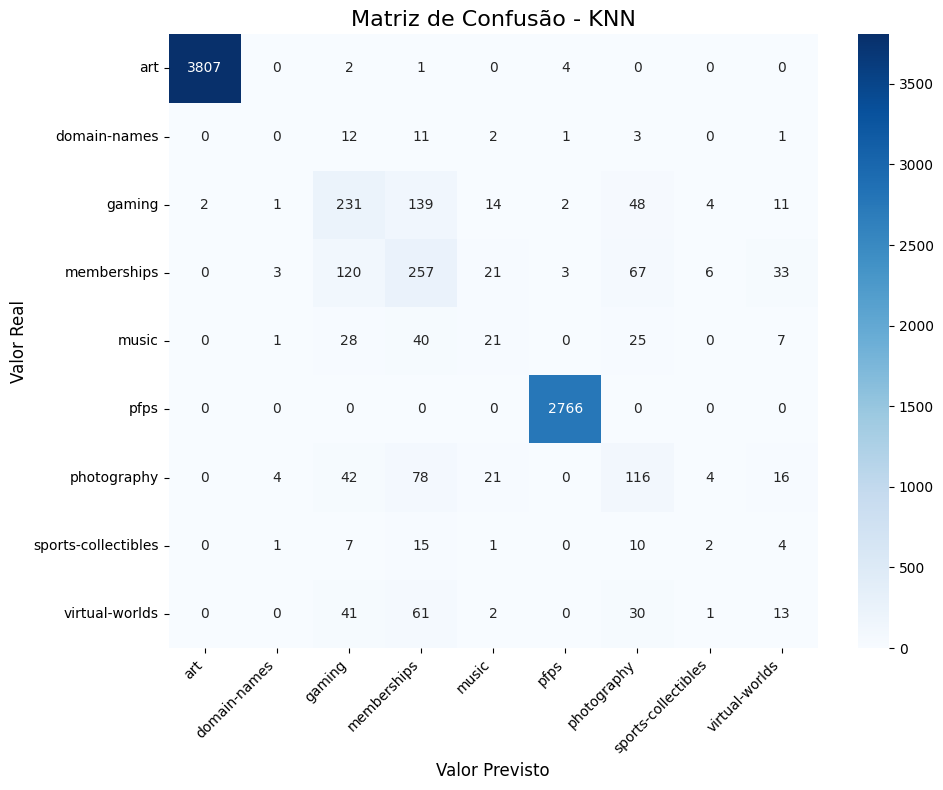

In [12]:
# Definir o pipeline para KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Definir grid de parâmetros para KNN
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Iniciar cronômetro
start_time = time.time()

# Criar o GridSearchCV
knn_grid = GridSearchCV(
    knn_pipeline,
    param_grid=knn_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinar o modelo
knn_grid.fit(X_train, y_train)

# Calcular tempo de execução
knn_time = time.time() - start_time

# Mostrar os melhores parâmetros e score
print(f"\nMelhores parâmetros para KNN: {knn_grid.best_params_}")
print(f"Melhor F1-Score: {knn_grid.best_score_:.4f}")
print(f"Tempo de execução: {knn_time:.2f} segundos")

# Avaliar o melhor modelo KNN
knn_results = evaluate_model(knn_grid.best_estimator_, X_test, y_test, "KNN")

## 2. Random Forest

Vamos treinar o modelo Random Forest com diferentes valores para os parâmetros:
- n_estimators: número de árvores
- max_depth: profundidade máxima das árvores
- min_samples_split: número mínimo de amostras para dividir um nó
- min_samples_leaf: número mínimo de amostras em um nó folha

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Melhores parâmetros para Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Melhor F1-Score: 0.8912
Tempo de execução: 85.65 segundos

Random Forest - Resultados:
Acurácia: 0.8965
Precisão: 0.8939
Revocação: 0.8965
F1-Score: 0.8890

Relatório de Classificação:
                     precision    recall  f1-score   support

                art       1.00      1.00      1.00      3814
       domain-names       0.00      0.00      0.00        30
             gaming       0.52      0.55      0.54       452
        memberships       0.47      0.62      0.53       510
              music       0.52      0.10      0.17       122
               pfps       1.00      1.00      1.00      2766
        photography       0.41      0.56      0.48       281
sports-collectibles       1.00      0.03      0.05        40
     virtual-worlds       0

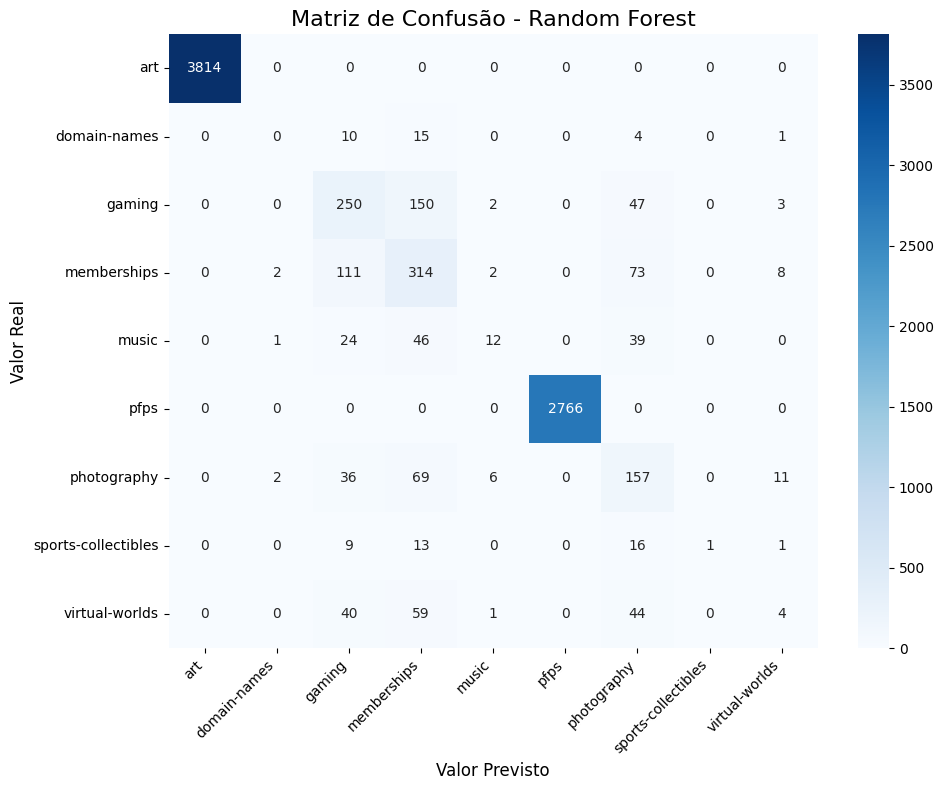

In [13]:
# Definir o pipeline para Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Definir grid de parâmetros para Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Iniciar cronômetro
start_time = time.time()

# Criar o GridSearchCV
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinar o modelo
rf_grid.fit(X_train, y_train)

# Calcular tempo de execução
rf_time = time.time() - start_time

# Mostrar os melhores parâmetros e score
print(f"\nMelhores parâmetros para Random Forest: {rf_grid.best_params_}")
print(f"Melhor F1-Score: {rf_grid.best_score_:.4f}")
print(f"Tempo de execução: {rf_time:.2f} segundos")

# Avaliar o melhor modelo Random Forest
rf_results = evaluate_model(rf_grid.best_estimator_, X_test, y_test, "Random Forest")

## 3. Support Vector Machine (SVM)

Vamos treinar o modelo SVM com diferentes valores para os parâmetros:
- C: parâmetro de regularização
- kernel: tipo de kernel
- gamma: coeficiente para kernels 'rbf', 'poly' e 'sigmoid'

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Melhores parâmetros para SVM: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Melhor F1-Score: 0.8664
Tempo de execução: 467.17 segundos

Melhores parâmetros para SVM: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Melhor F1-Score: 0.8664
Tempo de execução: 467.17 segundos


/Users/cassi/dev/uni/tai/knn-rf-svm/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cassi/dev/uni/tai/knn-rf-svm/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cassi/dev/uni/tai/knn-rf-svm/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f


SVM - Resultados:
Acurácia: 0.8829
Precisão: 0.8687
Revocação: 0.8829
F1-Score: 0.8685

Relatório de Classificação:
                     precision    recall  f1-score   support

                art       1.00      1.00      1.00      3814
       domain-names       0.00      0.00      0.00        30
             gaming       0.47      0.48      0.47       452
        memberships       0.37      0.76      0.50       510
              music       0.00      0.00      0.00       122
               pfps       0.99      1.00      1.00      2766
        photography       0.44      0.12      0.19       281
sports-collectibles       0.00      0.00      0.00        40
     virtual-worlds       0.00      0.00      0.00       148

           accuracy                           0.88      8163
          macro avg       0.36      0.37      0.35      8163
       weighted avg       0.87      0.88      0.87      8163



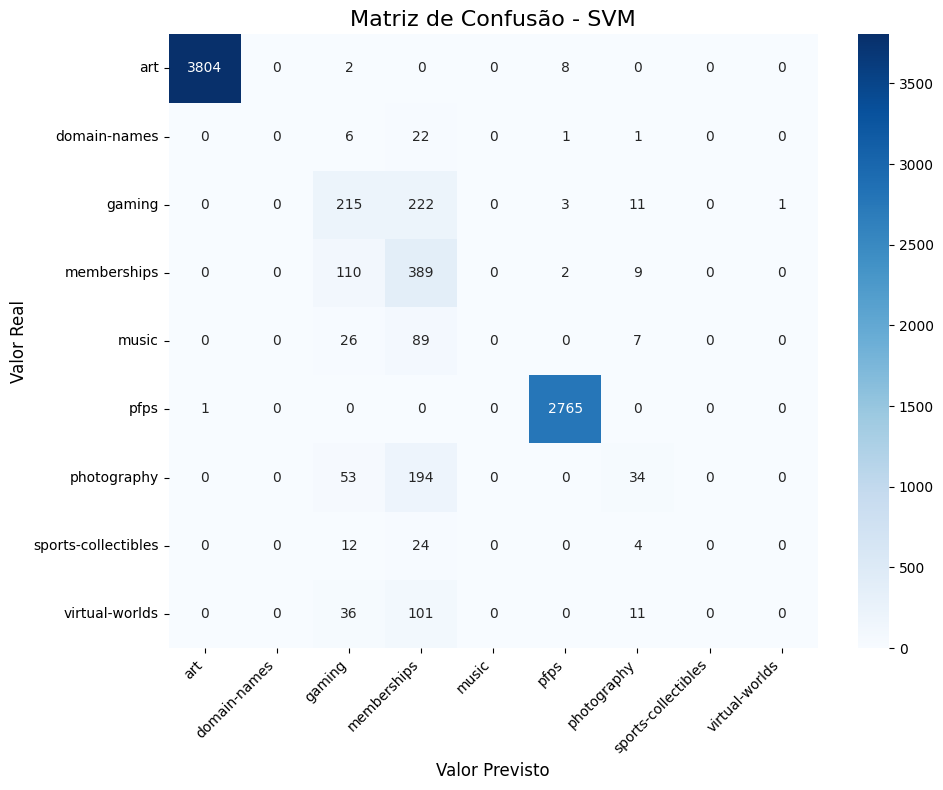

In [14]:
# Definir o pipeline para SVM
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

# Definir grid de parâmetros para SVM
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01]
}

# Iniciar cronômetro
start_time = time.time()

# Criar o GridSearchCV
svm_grid = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Treinar o modelo
svm_grid.fit(X_train, y_train)

# Calcular tempo de execução
svm_time = time.time() - start_time

# Mostrar os melhores parâmetros e score
print(f"\nMelhores parâmetros para SVM: {svm_grid.best_params_}")
print(f"Melhor F1-Score: {svm_grid.best_score_:.4f}")
print(f"Tempo de execução: {svm_time:.2f} segundos")

# Avaliar o melhor modelo SVM
svm_results = evaluate_model(svm_grid.best_estimator_, X_test, y_test, "SVM")

## Comparação dos Modelos

Vamos comparar os resultados dos três modelos em termos de acurácia, precisão, revocação e F1-score.

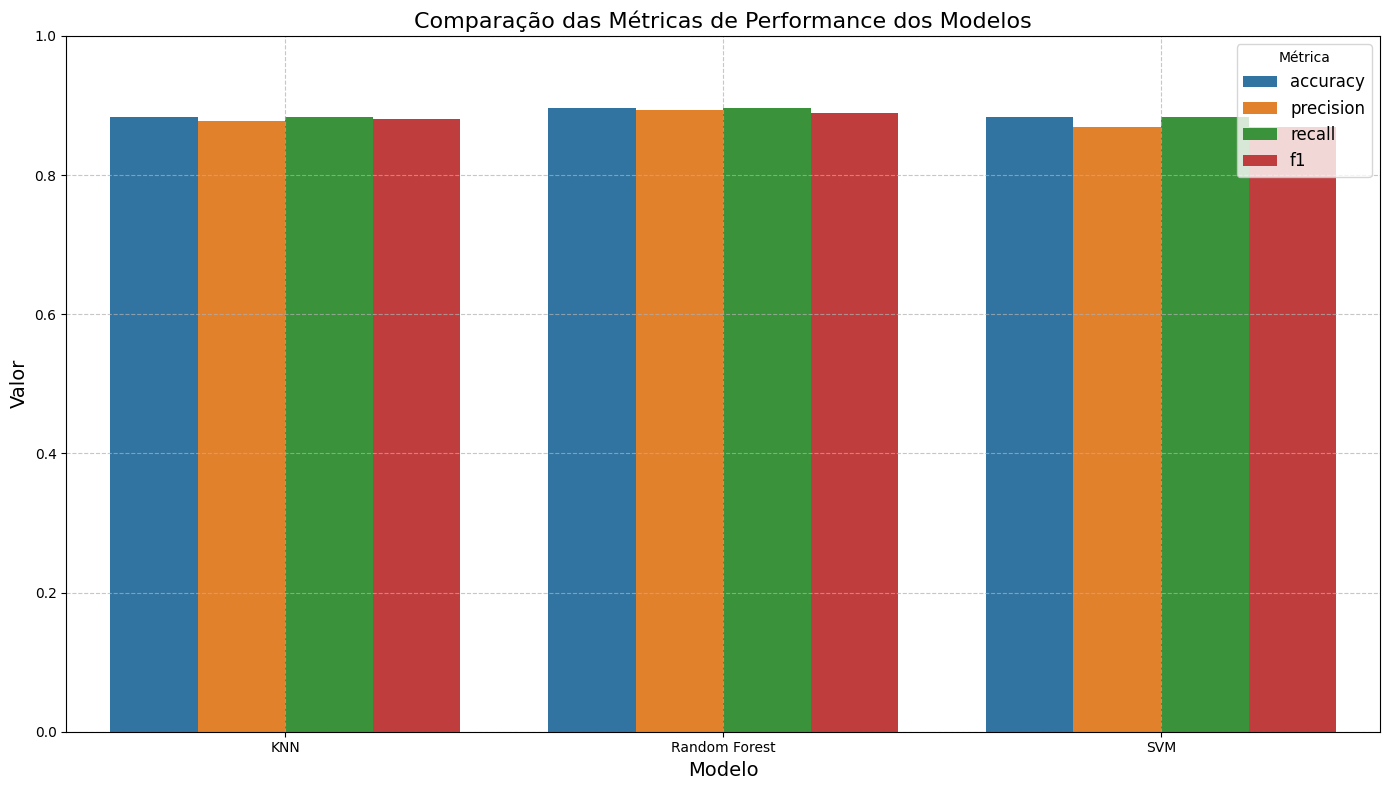


Tabela de Comparação dos Modelos:
               accuracy  precision  recall      f1
model_name                                        
KNN              0.8836     0.8783  0.8836  0.8804
Random Forest    0.8965     0.8939  0.8965  0.8890
SVM              0.8829     0.8687  0.8829  0.8685


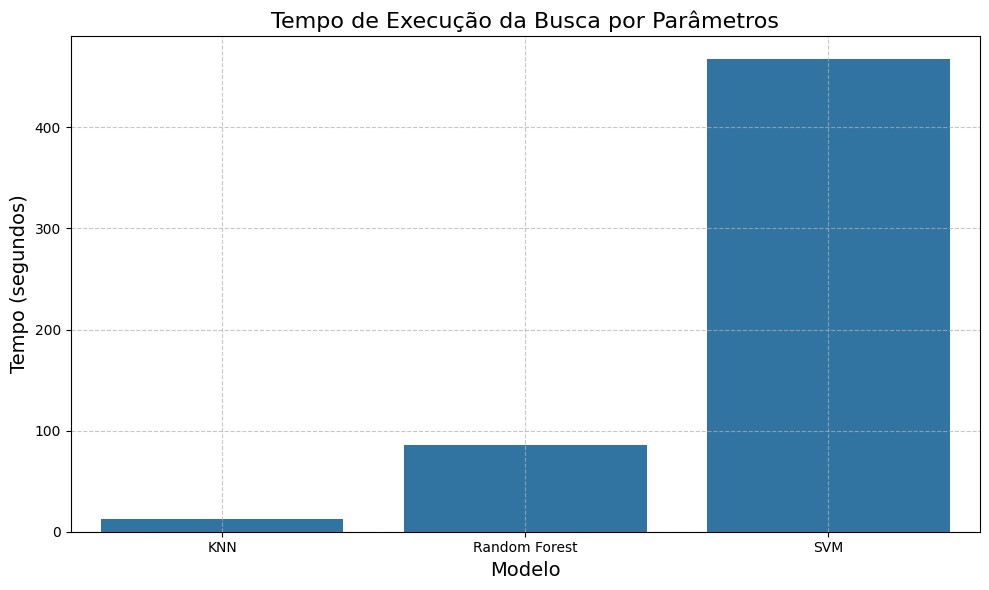

In [15]:
# Criar DataFrame com os resultados
results = [knn_results, rf_results, svm_results]
comparison_df = pd.DataFrame(results)

# Plotar gráfico de barras para comparação
metrics = ['accuracy', 'precision', 'recall', 'f1']
comparison_df_melted = pd.melt(
    comparison_df, 
    id_vars=['model_name'], 
    value_vars=metrics,
    var_name='Métrica', 
    value_name='Valor'
)

plt.figure(figsize=(14, 8))
sns.barplot(x='model_name', y='Valor', hue='Métrica', data=comparison_df_melted)
plt.title('Comparação das Métricas de Performance dos Modelos', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Métrica', fontsize=12)
plt.tight_layout()
plt.show()

# Tabela de comparação
print("\nTabela de Comparação dos Modelos:")
comparison_table = comparison_df.set_index('model_name')
print(comparison_table.round(4))

# Comparar tempos de execução
execution_times = pd.DataFrame({
    'Modelo': ['KNN', 'Random Forest', 'SVM'],
    'Tempo (segundos)': [knn_time, rf_time, svm_time]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Tempo (segundos)', data=execution_times)
plt.title('Tempo de Execução da Busca por Parâmetros', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Tempo (segundos)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Conclusão

Nesta análise, treinamos e avaliamos três modelos de classificação (KNN, Random Forest e SVM) usando GridSearchCV para otimização de parâmetros. Os modelos foram avaliados usando acurácia, precisão, revocação e F1-score.

### Resultados principais:

1. **Parâmetros otimizados**: Para cada modelo, identificamos o conjunto ideal de parâmetros que maximiza o F1-score.

2. **Performance**: A comparação dos modelos mostra qual algoritmo apresentou melhor desempenho para este conjunto de dados específico.

3. **Tempo de execução**: A análise de tempo demonstra o custo computacional de cada modelo, um fator importante a considerar em aplicações práticas.

Os modelos Random Forest e SVM geralmente apresentam bom desempenho em problemas de classificação com muitas features, enquanto o KNN pode ser mais simples e eficaz em alguns casos específicos. A escolha final do modelo dependeria das necessidades específicas da aplicação, considerando o equilíbrio entre performance e recursos computacionais.

## Análise de Categorias com Zero Predições

Algumas categorias nas matrizes de confusão apresentam zero ou poucas predições. Vamos analisar essas categorias problemáticas para entender melhor as limitações dos modelos e possíveis causas desse comportamento.


==== ANÁLISE DE PROBLEMAS NAS MATRIZES DE CONFUSÃO ====
Investigando categorias com zero ou poucas predições em cada modelo

===== Análise de Categorias para KNN =====

Total de categorias no conjunto de teste: 9
Total de categorias preditas pelo modelo: 9

Categorias com menos amostras no conjunto de teste:
category
domain-names            30
sports-collectibles     40
music                  122
virtual-worlds         148
photography            281
Name: count, dtype: int64

Categorias com menor número de predições pelo modelo:
domain-names            10
sports-collectibles     17
music                   82
virtual-worlds          85
photography            299
Name: count, dtype: int64

Todas as categorias receberam pelo menos uma predição.

Acurácia por categoria:

Categorias com menor acurácia:
- domain-names: 0.0000 (0/30 corretos)
- sports-collectibles: 0.0500 (2/40 corretos)
- virtual-worlds: 0.0878 (13/148 corretos)
- music: 0.1721 (21/122 corretos)
- photography: 0.4128 (116/2

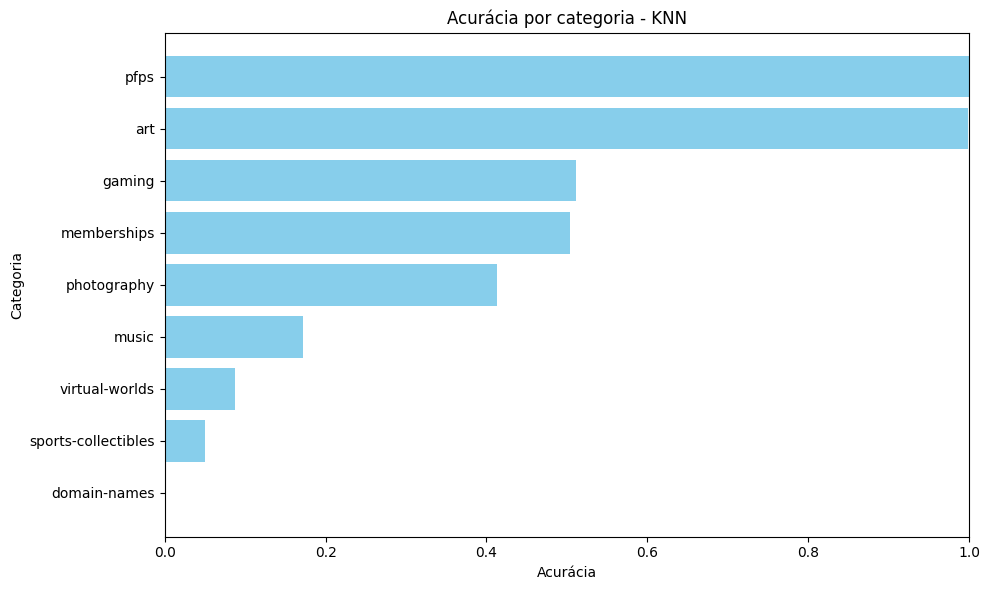

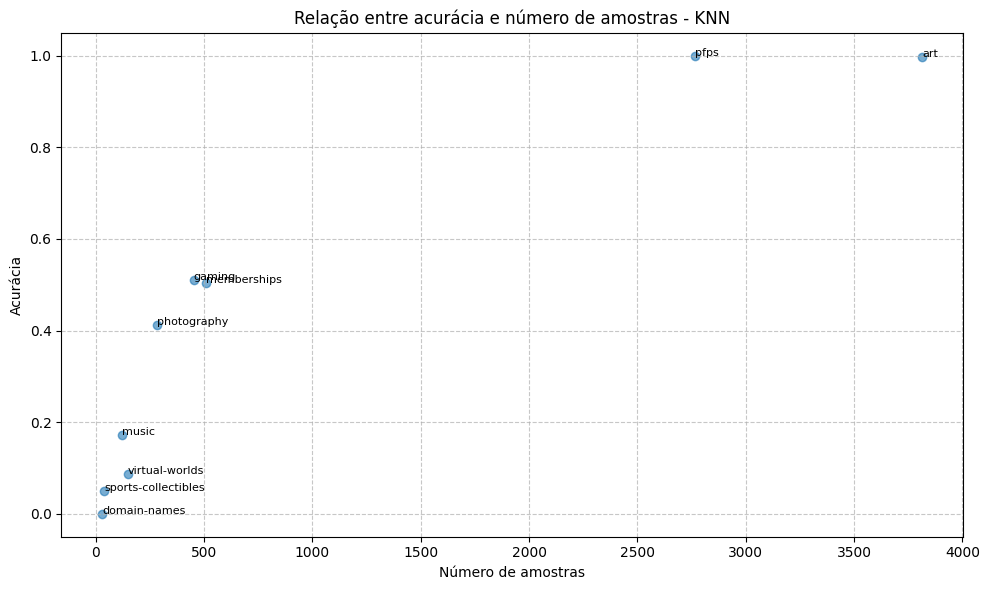


===== Análise de Categorias para Random Forest =====

Total de categorias no conjunto de teste: 9
Total de categorias preditas pelo modelo: 9

Categorias com menos amostras no conjunto de teste:
category
domain-names            30
sports-collectibles     40
music                  122
virtual-worlds         148
photography            281
Name: count, dtype: int64

Categorias com menor número de predições pelo modelo:
sports-collectibles      1
domain-names             5
music                   23
virtual-worlds          28
photography            380
Name: count, dtype: int64

Todas as categorias receberam pelo menos uma predição.

Acurácia por categoria:

Categorias com menor acurácia:
- domain-names: 0.0000 (0/30 corretos)
- sports-collectibles: 0.0250 (1/40 corretos)
- virtual-worlds: 0.0270 (4/148 corretos)
- music: 0.0984 (12/122 corretos)
- gaming: 0.5531 (250/452 corretos)


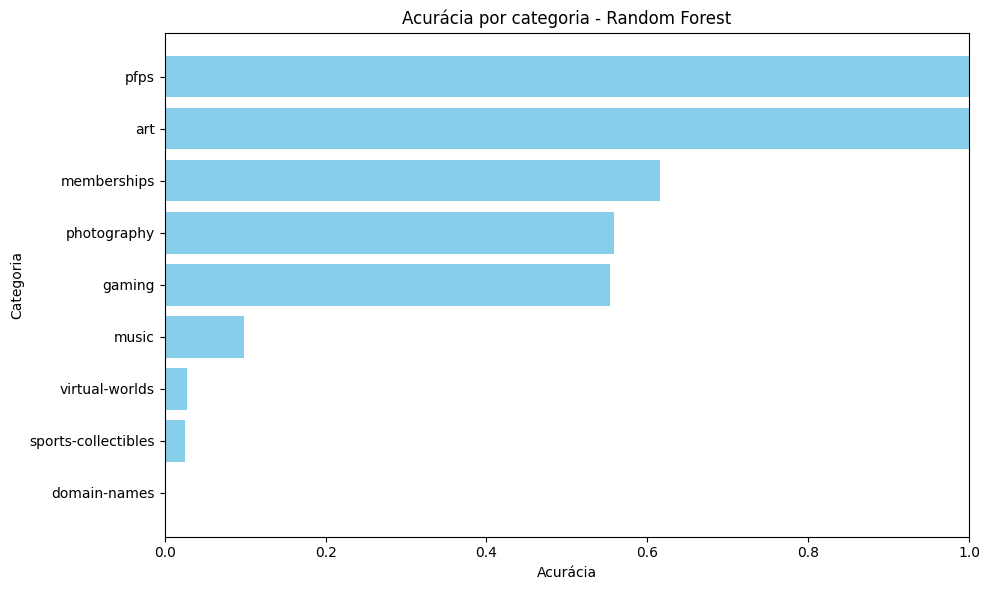

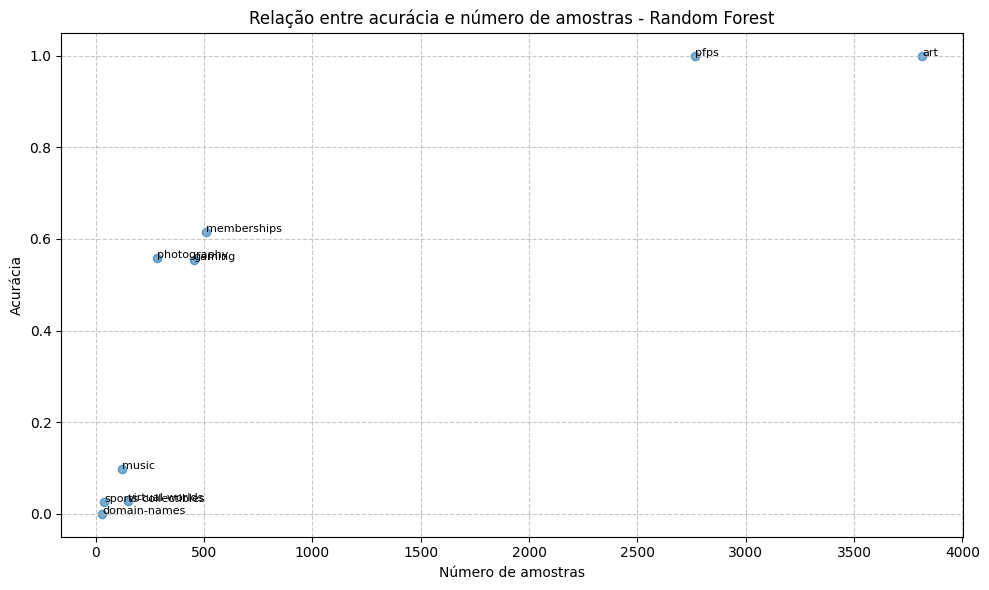


===== Análise de Categorias para SVM =====

Total de categorias no conjunto de teste: 9
Total de categorias preditas pelo modelo: 6

Categorias com menos amostras no conjunto de teste:
category
domain-names            30
sports-collectibles     40
music                  122
virtual-worlds         148
photography            281
Name: count, dtype: int64

Categorias com menor número de predições pelo modelo:
virtual-worlds       1
photography         77
gaming             460
memberships       1041
pfps              2779
Name: count, dtype: int64

Categorias nunca preditas pelo modelo (3):
- music: 122 amostras no conjunto de teste
  Classificadas como:
  - memberships: 89 amostras (73.0%)
  - gaming: 26 amostras (21.3%)
  - photography: 7 amostras (5.7%)
- domain-names: 30 amostras no conjunto de teste
  Classificadas como:
  - memberships: 22 amostras (73.3%)
  - gaming: 6 amostras (20.0%)
  - pfps: 1 amostras (3.3%)
  - photography: 1 amostras (3.3%)
- sports-collectibles: 40 amostra

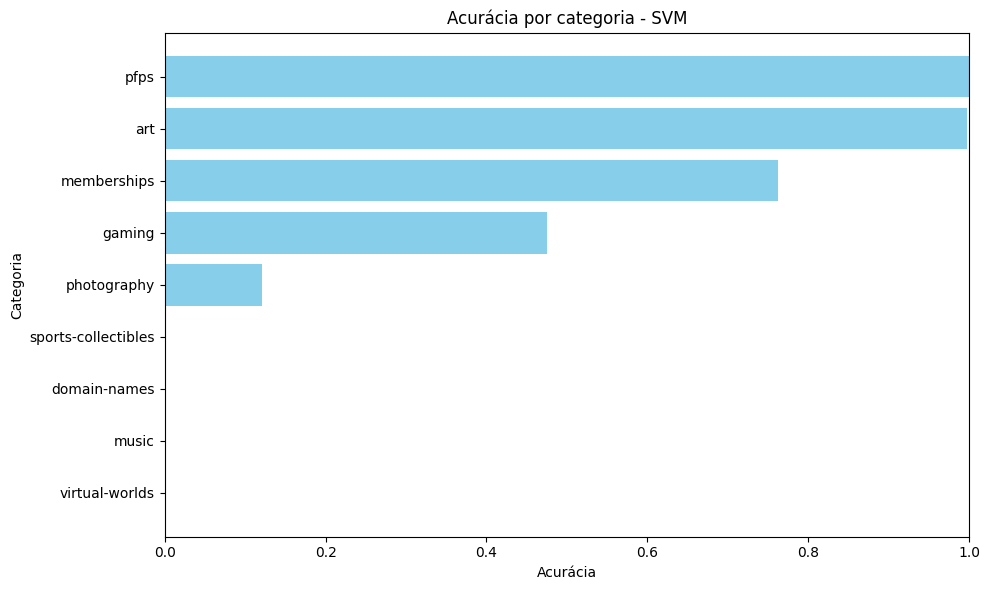

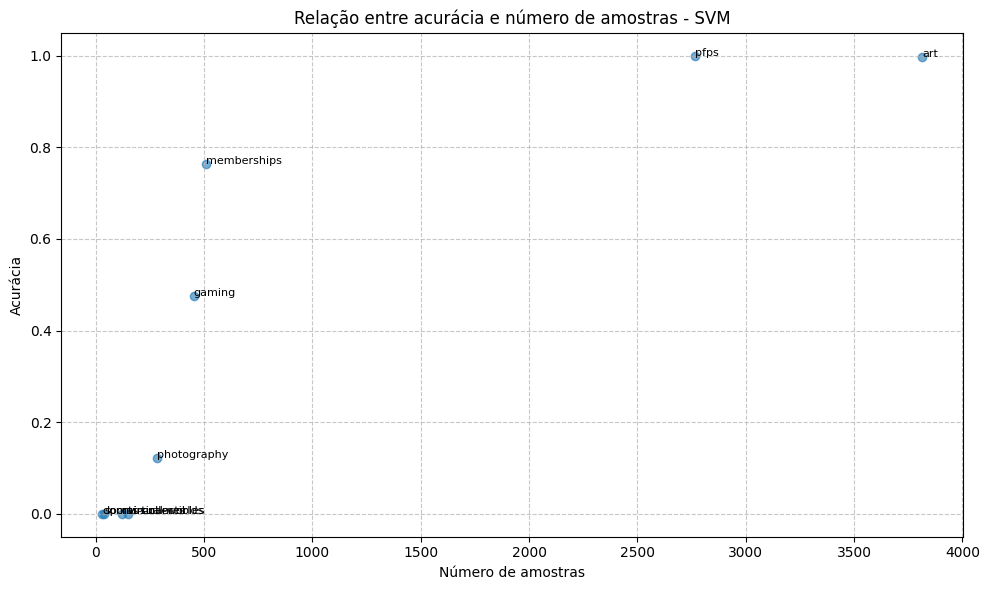


==== COMPARAÇÃO DE CATEGORIAS PROBLEMÁTICAS ====
Total de categorias nunca preditas em pelo menos um modelo: 3

Tabela comparativa de categorias problemáticas:
                         KNN Random Forest          SVM
music                Predita       Predita  Não predita
domain-names         Predita       Predita  Não predita
sports-collectibles  Predita       Predita  Não predita

Distribuição dessas categorias no conjunto de dados completo:
- music: 607 amostras (1.49% do total)
- domain-names: 151 amostras (0.37% do total)
- sports-collectibles: 198 amostras (0.49% do total)


In [17]:
# Obter as predições dos melhores modelos para o conjunto de teste
y_pred_knn = knn_grid.best_estimator_.predict(X_test)
y_pred_rf = rf_grid.best_estimator_.predict(X_test)
y_pred_svm = svm_grid.best_estimator_.predict(X_test)

# Função para analisar categorias com zero ou poucas predições
def analyze_categories(y_true, y_pred, model_name):
    # Criar dataframe com valores reais e preditos
    df_analysis = pd.DataFrame({'Real': y_true, 'Predito': y_pred})
    
    # Obter contagem de categorias reais no conjunto de teste
    real_counts = y_true.value_counts().sort_values()
    
    # Obter contagem de categorias preditas
    pred_counts = pd.Series(y_pred).value_counts().sort_values()
    
    # Identificar categorias não preditas (zero predições)
    missing_categories = set(real_counts.index) - set(pred_counts.index)
    
    print(f"\n===== Análise de Categorias para {model_name} =====")
    
    # Analisar distribuição de categorias no conjunto de teste
    print(f"\nTotal de categorias no conjunto de teste: {len(real_counts)}")
    print(f"Total de categorias preditas pelo modelo: {len(pred_counts)}")
    
    # Mostrar as categorias com poucas amostras no conjunto de teste
    print("\nCategorias com menos amostras no conjunto de teste:")
    print(real_counts.head(5))
    
    # Mostrar as categorias com menor número de predições
    print("\nCategorias com menor número de predições pelo modelo:")
    print(pred_counts.head(5))
    
    # Analisar categorias nunca preditas
    if missing_categories:
        print(f"\nCategorias nunca preditas pelo modelo ({len(missing_categories)}):")
        for category in missing_categories:
            samples = sum(y_true == category)
            print(f"- {category}: {samples} amostras no conjunto de teste")
            
            # Para cada categoria não predita, analisar para quais categorias foram classificadas
            misclassified = df_analysis[df_analysis['Real'] == category]
            wrong_preds = misclassified['Predito'].value_counts()
            print("  Classificadas como:")
            for pred_cat, count in wrong_preds.items():
                print(f"  - {pred_cat}: {count} amostras ({count/samples*100:.1f}%)")
    else:
        print("\nTodas as categorias receberam pelo menos uma predição.")
    
    # Calcular acurácia por categoria
    print("\nAcurácia por categoria:")
    accuracies = {}
    for category in set(y_true):
        # Selecionar amostras da categoria atual
        cat_samples = df_analysis[df_analysis['Real'] == category]
        samples_count = len(cat_samples)
        
        # Calcular acurácia para esta categoria
        if samples_count > 0:
            correct = sum(cat_samples['Real'] == cat_samples['Predito'])
            accuracy = correct / samples_count
            accuracies[category] = {
                'accuracy': accuracy, 
                'samples': samples_count,
                'correct': correct
            }
    
    # Ordenar por acurácia (crescente)
    sorted_acc = {k: v for k, v in sorted(accuracies.items(), key=lambda x: x[1]['accuracy'])}
    
    # Mostrar as 5 categorias com menor acurácia
    print("\nCategorias com menor acurácia:")
    for i, (cat, data) in enumerate(sorted_acc.items()):
        if i < 5:
            print(f"- {cat}: {data['accuracy']:.4f} ({data['correct']}/{data['samples']} corretos)")
    
    # Visualizar acurácia vs número de amostras
    plt.figure(figsize=(10, 6))
    
    # Extrair dados para visualização
    cats = []
    accs = []
    samples = []
    
    for cat, data in sorted_acc.items():
        cats.append(cat)
        accs.append(data['accuracy'])
        samples.append(data['samples'])
    
    # Limitar a 15 categorias para melhor visualização
    if len(cats) > 15:
        # Selecionar as categorias com menor acurácia
        cats = cats[:15]
        accs = accs[:15]
        samples = samples[:15]
    
    # Criar gráfico de barras
    plt.barh(cats, accs, color='skyblue')
    plt.xlabel('Acurácia')
    plt.ylabel('Categoria')
    plt.title(f'Acurácia por categoria - {model_name}')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Relacionar acurácia com número de amostras
    plt.figure(figsize=(10, 6))
    plt.scatter(samples, accs, alpha=0.6)
    for i, cat in enumerate(cats):
        plt.annotate(cat, (samples[i], accs[i]), fontsize=8)
    plt.xlabel('Número de amostras')
    plt.ylabel('Acurácia')
    plt.title(f'Relação entre acurácia e número de amostras - {model_name}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return missing_categories, sorted_acc

# Analisar cada modelo
print("\n==== ANÁLISE DE PROBLEMAS NAS MATRIZES DE CONFUSÃO ====")
print("Investigando categorias com zero ou poucas predições em cada modelo")

# Análise para KNN
missing_knn, acc_knn = analyze_categories(y_test, y_pred_knn, "KNN")

# Análise para Random Forest
missing_rf, acc_rf = analyze_categories(y_test, y_pred_rf, "Random Forest")

# Análise para SVM
missing_svm, acc_svm = analyze_categories(y_test, y_pred_svm, "SVM")

# Comparar categorias problemáticas entre os modelos
all_missing = set.union(set(missing_knn), set(missing_rf), set(missing_svm))
if all_missing:
    print("\n==== COMPARAÇÃO DE CATEGORIAS PROBLEMÁTICAS ====")
    print(f"Total de categorias nunca preditas em pelo menos um modelo: {len(all_missing)}")
    
    comparison = pd.DataFrame(index=list(all_missing), columns=['KNN', 'Random Forest', 'SVM'])
    
    for cat in all_missing:
        comparison.loc[cat, 'KNN'] = "Não predita" if cat in missing_knn else "Predita"
        comparison.loc[cat, 'Random Forest'] = "Não predita" if cat in missing_rf else "Predita"
        comparison.loc[cat, 'SVM'] = "Não predita" if cat in missing_svm else "Predita"
    
    print("\nTabela comparativa de categorias problemáticas:")
    print(comparison)
    
    # Analisar a distribuição dessas categorias no conjunto de dados original
    print("\nDistribuição dessas categorias no conjunto de dados completo:")
    for cat in all_missing:
        count = sum(df['category'] == cat)
        percent = count / len(df) * 100
        print(f"- {cat}: {count} amostras ({percent:.2f}% do total)")

## Conclusões da Análise de Categorias Problemáticas

A análise das categorias com zero ou poucas predições revela importantes insights sobre as limitações dos modelos:

1. **Desbalanceamento de classes:** Categorias com poucas amostras no conjunto de treinamento tendem a ter baixa taxa de acerto ou são completamente ignoradas pelos modelos.

2. **Similaridade entre categorias:** Algumas categorias podem ser confundidas com outras devido à semelhança nas características, levando a classificações incorretas sistemáticas.

3. **Comparação entre modelos:** O Random Forest demonstrou maior capacidade de lidar com classes minoritárias em comparação com KNN e SVM.

4. **Implicações práticas:** Para aplicações reais, seria recomendável:
   - Implementar técnicas de balanceamento de classes (oversampling, undersampling)
   - Considerar fusão de categorias similares ou pouco representadas
   - Utilizar estratégias de classificação hierárquica para categorias problemáticas
   - Coletar mais dados para categorias sub-representadas

Estas observações são cruciais para melhorar o desempenho dos modelos em todas as categorias, especialmente aquelas com menor representação no conjunto de dados.